认识数据

In [13]:
import pyreadstat

sav_file = "D:\学习资料\数据挖掘\实验报告\超市商品购买关联分析\数据-某日顾客商品购买明细.sav"

data_0211443, meta = pyreadstat.read_sav(sav_file, apply_value_formats=True)

# 查看数据
print(data_0211443.head())


       会员ID  商品   数量     单价     小计
0   36405.0  冻肉  1.0  15.68  15.68
1  109884.0  冻肉  2.0  15.68  31.36
2   85259.0  冻肉  1.0  15.68  15.68
3   78428.0  冻肉  1.0  15.68  15.68
4   78626.0  冻肉  1.0  15.68  15.68


In [14]:
# 查看数据结构和数据类型
data_0211443.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   会员ID    2800 non-null   float64
 1   商品      2800 non-null   object 
 2   数量      2800 non-null   float64
 3   单价      2800 non-null   float64
 4   小计      2800 non-null   float64
dtypes: float64(4), object(1)
memory usage: 109.5+ KB


生成描述性统计信息的函数，提供了每一列的统计概要，包括均值、标准差、最小值、25%分位数、中位数（50% 分位数）、75%分位数和最大值。

In [15]:
data_describe_0211443 = data_0211443.describe()

print(data_describe_0211443)

                会员ID           数量           单价           小计
count    2800.000000  2800.000000  2800.000000  2800.000000
mean    60099.010000     1.052143    13.168207    13.841600
std     29668.772892     0.280603     4.983840     6.477969
min     10150.000000     1.000000     3.990000     3.990000
25%     33172.000000     1.000000     9.500000     9.500000
50%     60571.000000     1.000000    15.000000    15.500000
75%     87101.000000     1.000000    17.350000    17.350000
max    109884.000000     5.000000    20.000000    80.000000


查看空缺值情况

In [16]:
data_null_0211443 = data_0211443.isnull()

null_count = data_0211443.isnull().sum()

print(data_null_0211443)
print(null_count)

       会员ID     商品     数量     单价     小计
0     False  False  False  False  False
1     False  False  False  False  False
2     False  False  False  False  False
3     False  False  False  False  False
4     False  False  False  False  False
...     ...    ...    ...    ...    ...
2795  False  False  False  False  False
2796  False  False  False  False  False
2797  False  False  False  False  False
2798  False  False  False  False  False
2799  False  False  False  False  False

[2800 rows x 5 columns]
会员ID    0
商品      0
数量      0
单价      0
小计      0
dtype: int64


数据准备

In [17]:
# 按会员ID进行排序
data_0211443.sort_values(by='会员ID', inplace=True)

# 打印排序后的数据
print(data_0211443.head())


         会员ID    商品   数量     单价     小计
1668  10150.0  蔬菜水果  1.0  17.35  17.35
2412  10150.0    饮料  1.0   6.50   6.50
198   10236.0    冻肉  1.0  15.68  15.68
1273  10236.0    啤酒  1.0   3.99   3.99
1267  10360.0    啤酒  1.0   3.99   3.99


In [18]:
# 创建购买状态列（购买为T，未购买为F）
data_0211443['购买状态'] = data_0211443['数量'].apply(lambda x: 'T' if x > 0 else 'F')
# 创建表，以 "会员ID" 为索引，"商品" 为列
data_basket_0211443 = data_0211443.pivot_table(index='会员ID', columns='商品', values='购买状态', aggfunc='max', fill_value='F')

print(data_basket_0211443.head())


商品      冻肉 啤酒 牛奶 甜食 罐装肉 罐装蔬菜 葡萄酒 蔬菜水果 饮料  鱼 鲜肉
会员ID                                          
10150.0  F  F  F  F   F    F   F    T  T  F  F
10236.0  T  T  F  F   F    F   F    F  F  F  F
10360.0  T  T  F  F   F    T   F    F  F  T  F
10451.0  T  T  F  T   F    T   F    F  F  F  F
10609.0  F  F  F  F   F    F   F    T  F  T  F


使用网络图观察数据间的购买联系

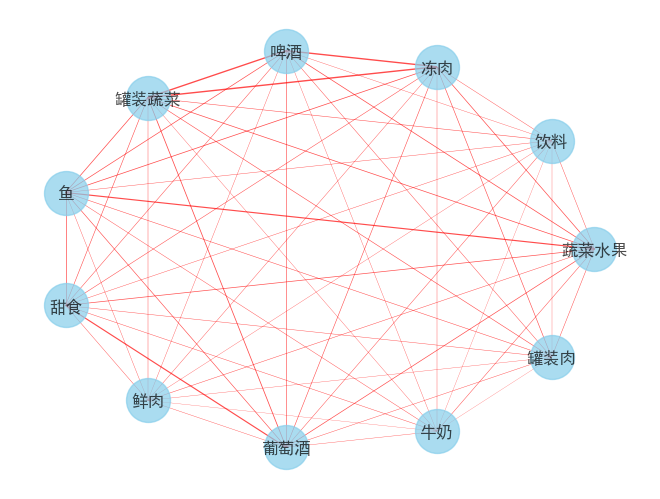

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

graph = nx.Graph()

# 遍历数据框的列和行，添加购买关系到图中
for _, row in (data_basket_0211443.iterrows()):
    products = row.index[row == 'T'].tolist()
    for i, product1 in enumerate(products):
        for product2 in products[i+1:]:
            # 如果边已存在，增加边的权重
            if graph.has_edge(product1, product2):
                graph[product1][product2]['weight'] += 1
            else:
                graph.add_edge(product1, product2, weight=1)
            
            
# 设置节点分散在外围
pos = nx.circular_layout(graph)
# 获取边的权重
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# 对权重进行归一化
normalized_edge_weights = [w / max(edge_weights) for w in edge_weights]
# 画网络图，边的粗细表示权重
nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=1000, node_color='skyblue', width=normalized_edge_weights, edge_color='red', alpha=0.7)

plt.show()

频数的方式显示各商品的关联程度

In [29]:
import pandas as pd

# 创建一个空的 DataFrame
association_df_0211443 = pd.DataFrame(columns=['Product1', 'Product2', 'Frequency'])

# 遍历图中的边，将关联程度添加到 DataFrame 中
for edge in graph.edges(data=True):
    product1, product2, frequency = edge[0], edge[1], edge[2]['weight']
    row = pd.DataFrame({'Product1': [product1], 'Product2': [product2], 'Frequency': [frequency]})
    association_df_0211443 = pd.concat([association_df_0211443, row], ignore_index=True)

# 按照 'Frequency' 列进行排序，降序排列
association_df_0211443 = association_df_0211443.sort_values(by='Frequency', ascending=False)
# 重置索引
association_df_0211443 = association_df_0211443.reset_index(drop=True)

# 显示新的关联程度表格
print(association_df_0211443)



   Product1 Product2 Frequency
0        冻肉     罐装蔬菜       173
1        冻肉       啤酒       170
2        啤酒     罐装蔬菜       167
3      蔬菜水果        鱼       145
4        甜食      葡萄酒       144
5      罐装蔬菜      葡萄酒        97
6        冻肉        鱼        90
7      蔬菜水果       啤酒        89
8      罐装蔬菜        鱼        89
9      蔬菜水果       冻肉        86
10     蔬菜水果     罐装蔬菜        86
11        鱼       甜食        86
12       啤酒        鱼        85
13     蔬菜水果      葡萄酒        84
14     蔬菜水果       甜食        83
15        鱼      葡萄酒        78
16       啤酒      葡萄酒        77
17       冻肉      罐装肉        75
18     罐装蔬菜      罐装肉        73
19     罐装蔬菜       甜食        71
20       冻肉      葡萄酒        71
21       冻肉       甜食        66
22       啤酒       甜食        64
23        鱼      罐装肉        63
24       饮料     罐装蔬菜        63
25     蔬菜水果       牛奶        62
26     蔬菜水果      罐装肉        61
27       饮料      葡萄酒        60
28       啤酒      罐装肉        60
29     蔬菜水果       鲜肉        59
30       甜食       牛奶        56
31      

Apriori模型

In [27]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df_0211443 = pd.DataFrame(data_basket_0211443)

# 将数据集中的 'T' 和 'F' 转换为 1 和 0
df_0211443.replace({'T': 1, 'F': 0}, inplace=True)

# 使用 Apriori 算法找出频繁项集
frequent_itemsets = apriori(df_0211443, min_support=0.1, use_colnames=True)
# 设置 min_support=0.1，表示只保留在数据集中出现频率超过 10% 的项集。

# 使用关联规则挖掘
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
# 设置 min_threshold=0.7，表示只保留置信度大于等于 0.7 的关联规则。

# 显示频繁项集
print("频繁项集:")
print(frequent_itemsets)

# 显示关联规则
print("\n关联规则:")
print(rules)

频繁项集:
     support        itemsets
0   0.321619            (冻肉)
1   0.312034            (啤酒)
2   0.188498            (牛奶)
3   0.293930            (甜食)
4   0.217252           (罐装肉)
5   0.322684          (罐装蔬菜)
6   0.304579           (葡萄酒)
7   0.318424          (蔬菜水果)
8   0.195953            (饮料)
9   0.310969             (鱼)
10  0.193823            (鲜肉)
11  0.181044        (啤酒, 冻肉)
12  0.184239      (罐装蔬菜, 冻肉)
13  0.177849      (啤酒, 罐装蔬菜)
14  0.153355       (甜食, 葡萄酒)
15  0.103301     (罐装蔬菜, 葡萄酒)
16  0.154420       (鱼, 蔬菜水果)
17  0.155485  (啤酒, 罐装蔬菜, 冻肉)

关联规则:
  antecedents consequents  antecedent support  consequent support   support  \
0  (啤酒, 罐装蔬菜)        (冻肉)            0.177849            0.321619  0.155485   
1    (啤酒, 冻肉)      (罐装蔬菜)            0.181044            0.322684  0.155485   
2  (罐装蔬菜, 冻肉)        (啤酒)            0.184239            0.312034  0.155485   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.874251  2.718285  0.098285    5.394746       0.76

D:\pythonProject\Project1\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
